# EJERCICIO 1


## Preparación del entorno.

In [1]:
pip install pydub

### Importar librerías

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import pydub
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from IPython.display import Audio, display
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report



In [3]:


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Establecer GPU por defecto en caso de estar disponible.

In [4]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

### Descargar dataset:

In [5]:
dataset, info = tfds.load('spoken_digit', with_info=True,
                          as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2500 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/spoken_digit/incomplete.0ZHUM6_1.0.9/spoken_digit-train.tfrecord*...:   0%…

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.


### Análisis del dataset

In [6]:
print(info)

tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav
    files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the
    beginnings and ends.
    
    5 speakers\
    2,500 recordings (50 of each digit per speaker)\
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_dir=PosixGPath('/tmp/tmp_gt6dq59tfds'),
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=int64),
        'audio/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    su

In [7]:
print(info.splits)

{Split('train'): <SplitInfo num_examples=2500, num_shards=1>}


In [8]:
dataset

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [9]:
# Obtener los nombres de las clases (etiquetas)
class_names = info.features['label'].names
print("Nombres de las clases:", class_names)

Nombres de las clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Comprobamos que el dataset esté balanceado.

In [10]:
# Crear un diccionario para contar las muestras por clase
class_counts = {class_name: 0 for class_name in class_names}

# Contar las muestras por clase
for example, label in dataset['train']:
    class_name = class_names[label.numpy()]
    class_counts[class_name] += 1

# Mostrar los resultados
for class_name, count in class_counts.items():
    print(f"Clase {class_name}: {count} muestras")



Clase 0: 250 muestras
Clase 1: 250 muestras
Clase 2: 250 muestras
Clase 3: 250 muestras
Clase 4: 250 muestras
Clase 5: 250 muestras
Clase 6: 250 muestras
Clase 7: 250 muestras
Clase 8: 250 muestras
Clase 9: 250 muestras


Revisamos las longitudes máximas, mínimas y promedio del los audios. Además, por lo que podemos ver en ***info*** del dataset, los clips de audio están a a 8kHz (8000 muestras por segundo). Vamos a ver si hay alguno que esté por encima de los 8000.

La longitud máxima es: 18262
La longitud mínima es: 1148
La longitud promedio es: 3280.63
La desviación estándar de las longitudes es: 1025.71
Número de audios que están por encima del umbral (8000): 4
Audio 1 (longitud: 8281):


Audio 2 (longitud: 8201):


Audio 3 (longitud: 18262):


Audio 4 (longitud: 17567):


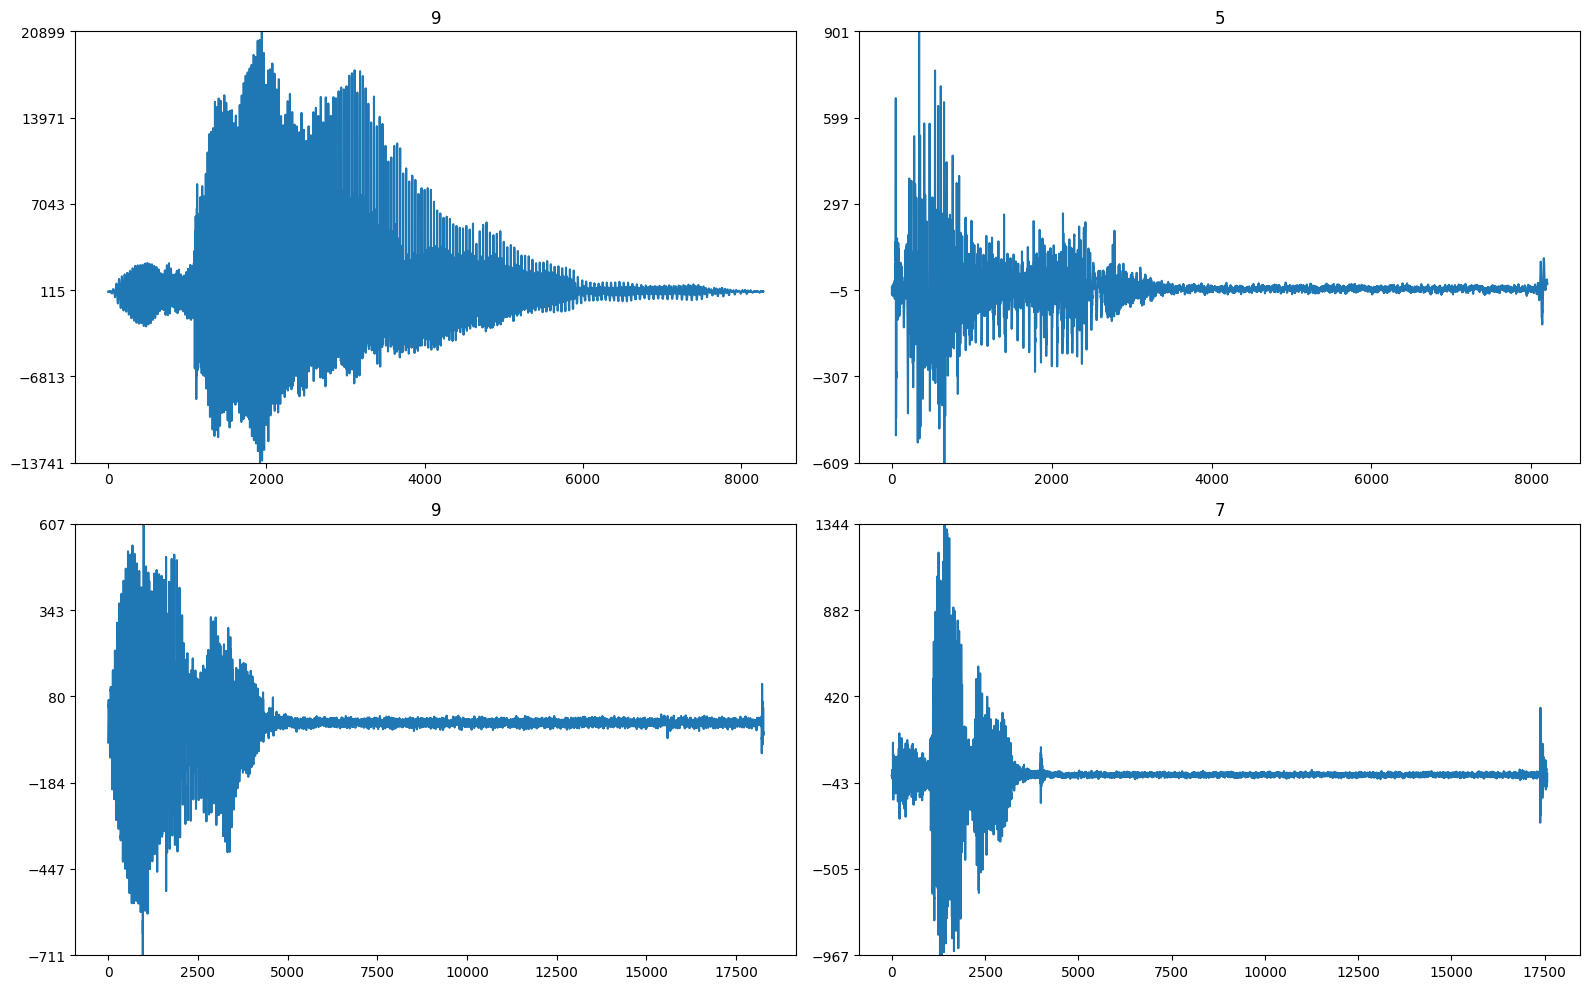

In [11]:


# Función para obtener la longitud del audio
def get_audio_length(audio):
    return tf.shape(audio)[0]

# Inicializar una lista para almacenar las longitudes y los audios correspondientes
lengths = []
audios = []
labels =[]
# Recorrer el dataset para obtener todas las longitudes y audios
for audio, label in dataset['train']:
    length = get_audio_length(audio).numpy()
    lengths.append(length)
    audios.append(audio.numpy())
    labels.append(label.numpy())

# Convertir la lista de longitudes a un array de numpy
lengths = np.array(lengths)

# Calcular estadísticas
max_length = np.max(lengths)
min_length = np.min(lengths)
avg_length = np.mean(lengths)
std_length = np.std(lengths)

print(f"La longitud máxima es: {max_length}")
print(f"La longitud mínima es: {min_length}")
print(f"La longitud promedio es: {avg_length:.2f}")
print(f"La desviación estándar de las longitudes es: {std_length:.2f}")

# Identificar audios que están muy por encima del umbral
threshold = 8000
long_audios = [(audio, length, labels) for audio, length, labels in zip(audios, lengths, labels) if length > threshold]

print(f"Número de audios que están por encima del umbral ({threshold}): {len(long_audios)}")
plt.figure(figsize=(16, 10))
rows = len(long_audios)//2
cols = len(long_audios)//2
n = rows * cols
# Reproducir los audios largos
for i, (audio, length, label) in enumerate(long_audios):
    print(f"Audio {i + 1} (longitud: {length}):")
    display(Audio(audio, rate=threshold))
    plt.subplot(rows, cols, i + 1)
    audio_signal = audio
    min_val = np.min(audio_signal)
    max_val = np.max(audio_signal)
    plt.plot(audio_signal)
    plt.title(label)
    plt.yticks(np.arange(min_val, max_val + 1, (max_val - min_val) / 5))
    plt.ylim([min_val, max_val])
plt.tight_layout()
plt.show()

Encontramos 4 audios por encima del umbral (8000), pero al escucharlos y ver su forma de onda notamos que la parte importante del sonido está por debajo. Con la función ***preprocess_audio*** dejamos todos los audios del mismo tamaño (8000), agregando padding para que todos los ejemplos duren exactamente 1 segundo (y truncando los que son más largos).

In [64]:

# Definir una función para ajustar el tamaño de los audios
def preprocess_audio(audio, label, desired_length=8000):
    # Obtener la longitud del audio actual
    audio_length = tf.shape(audio)[0]

    # Si el audio es más largo que el tamaño deseado, se trunca
    if tf.greater(audio_length, desired_length):
        audio = tf.slice(audio, [0], [desired_length])
    # Si el audio es más corto que el tamaño deseado, se rellena con ceros
    else:
        padding = desired_length - audio_length
        audio = tf.pad(audio, paddings=[[0, padding]], mode='CONSTANT')

    return audio, label


# Acceder a la división 'train' del conjunto de datos
train_dataset = dataset['train']

# Aplicar la función de preprocesamiento al conjunto de datos
desired_length = 8000
train_dataset = train_dataset.map(lambda audio, label: preprocess_audio(audio, label, desired_length))


In [13]:
# Aplicar el batching al conjunto de datos preprocesado
batch_size = 64
train_dataset = train_dataset.batch(batch_size)




In [14]:
for batch_audio, batch_label in train_dataset.take(1):
    print(f'Batch audio shape: {batch_audio.shape}')
    print(f'Batch label shape: {batch_label.shape}')

Batch audio shape: (64, 8000)
Batch label shape: (64,)


### Ploteamos la forma de onda para otros ejemplos.

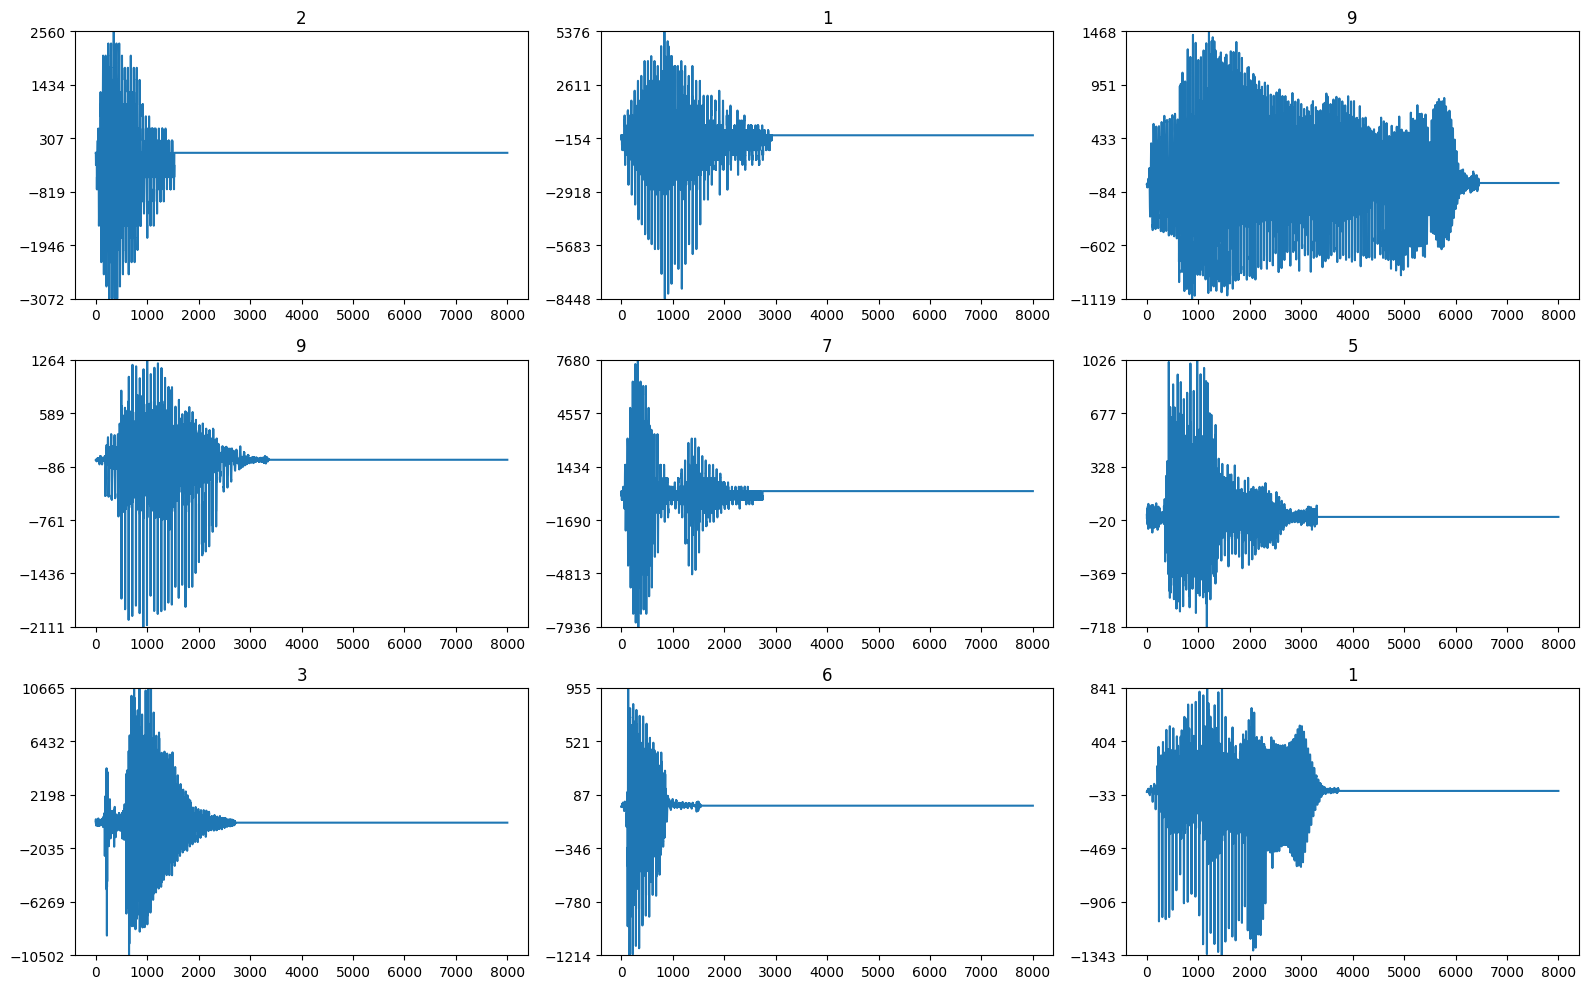

In [15]:


plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i + 1)
    audio_signal = batch_audio[i]
    min_val = np.min(audio_signal)
    max_val = np.max(audio_signal)
    plt.plot(audio_signal)
    plt.title(class_names[batch_label[i]])
    plt.yticks(np.arange(min_val, max_val + 1, (max_val - min_val) / 5))
    plt.ylim([min_val, max_val])
plt.tight_layout()
plt.show()

### Convertir formas de onda a espectrogramas

In [16]:
# Define la función get_spectrogram
def get_spectrogram(waveform, dtype=tf.float32):
    # Convertir el waveform a un tipo de datos de punto flotante
    waveform = tf.cast(waveform, dtype)

    # Convertir el waveform a un espectrograma usando STFT
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)

    # Calcular la magnitud del STFT
    spectrogram = tf.abs(spectrogram)

    # Agregar una dimensión `channels` para usarlo como entrada de datos tipo imagen
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram

In [65]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convertir las frecuencias a escala logarítmica y transponer, de modo que el tiempo
  # esté representado en el eje x (columnas).
  # Añadir un epsilon para evitar tomar el logaritmo de cero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

 Reproducir el audio original de un ejemplo, imprimir sus formas de onda y espectrograma correspondiente

In [18]:
for i in range(3):
  label = class_names[batch_label[i]]
  waveform = batch_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display(Audio(waveform, rate=8000))

Label: 2
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 1
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 9
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


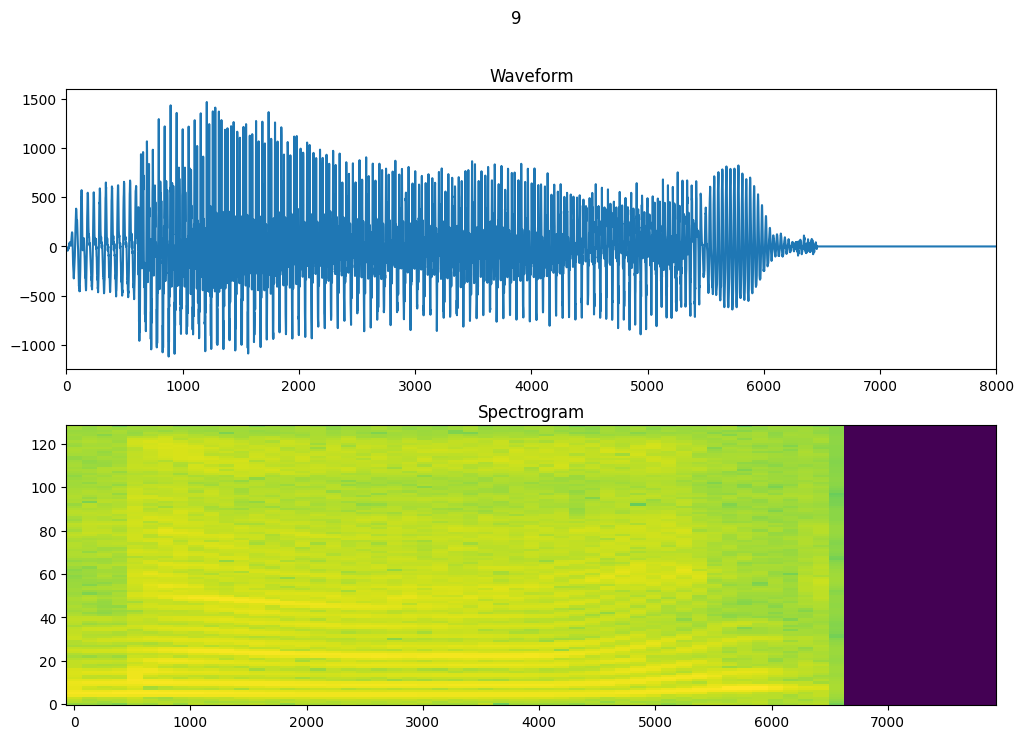

In [19]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Ahora creamos un dataset de espectrogramas utilizando la función definida.

In [20]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
train_spectrogram_ds = make_spec_ds(train_dataset)


Examinar el espectrograma para distintos ejemplos del dataset.

In [22]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

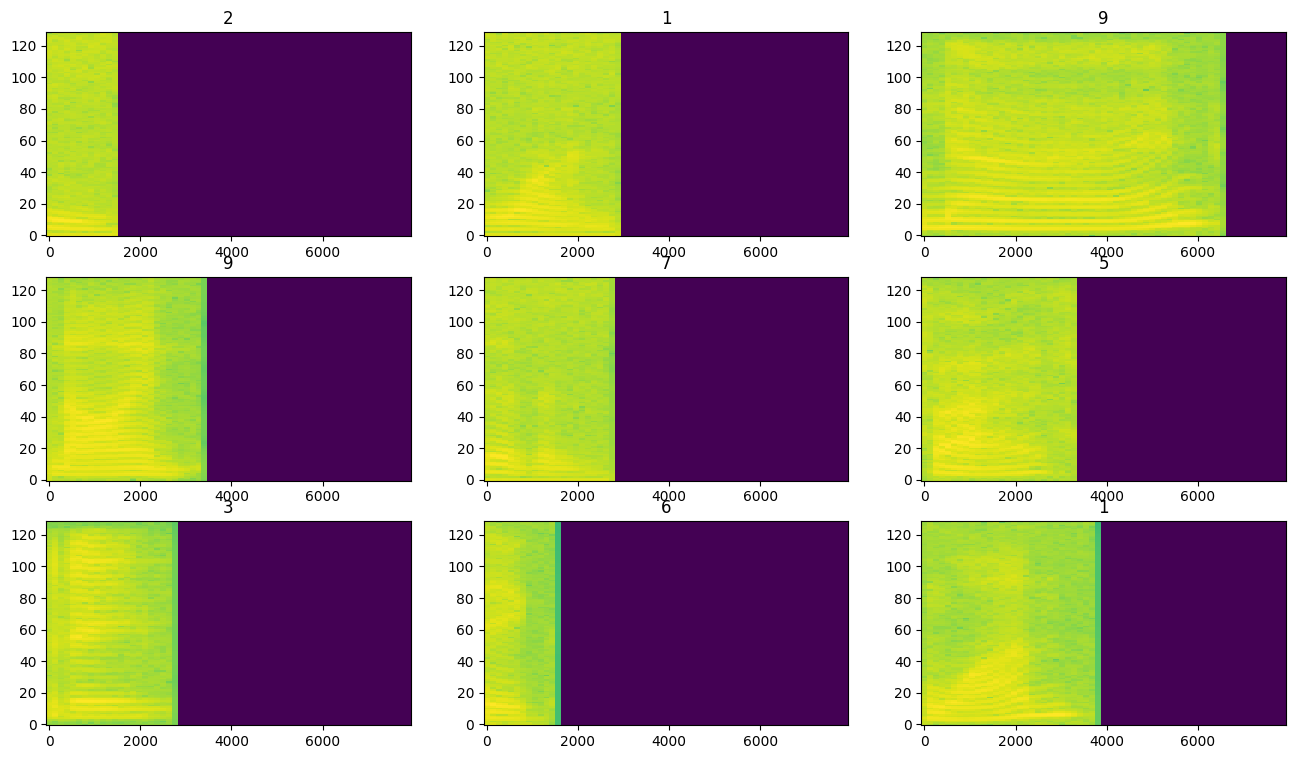

In [23]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(class_names[example_spect_labels[i].numpy()])

plt.show()

Dividimos el dataset en train y val (2000 y 500, respectivamente).

In [24]:
# Dividir el conjunto de datos en entrenamiento y prueba

train_size = int(0.8 * len(train_spectrogram_ds))  # 80% para entrenamiento
test_size = len(train_spectrogram_ds) - train_size  # 20% para prueba

train_ds = train_spectrogram_ds.take(train_size)
val_ds = train_spectrogram_ds.skip(train_size).take(test_size)

# Imprimir el tamaño de los conjuntos de datos
print(f"Tamaño del conjunto de entrenamiento: {train_size}")
print(f"Tamaño del conjunto de prueba: {test_size}")

Tamaño del conjunto de entrenamiento: 32
Tamaño del conjunto de prueba: 8


## Construir y Entrenar el Modelo Convolucional

In [25]:
# Verificar el primer ejemplo transformado
for spectrogram, label in train_ds.take(1):
    print(f'Spectrogram shape: {spectrogram.shape}')
    print(f'Label: {label}')

Spectrogram shape: (64, 61, 129, 1)
Label: [2 1 9 9 7 5 3 6 1 8 1 5 5 4 8 6 4 6 4 2 4 3 3 7 4 0 6 4 7 8 1 9 6 7 7 4 6
 8 3 2 4 5 8 2 9 9 2 9 9 1 5 2 6 7 5 8 1 0 9 1 8 9 8 0]


Optimizamos la carga del dataset

In [26]:
# Prefetch para mejorar el rendimiento
train_ds_spectrogram = train_ds.cache().shuffle(3000).prefetch(tf.data.AUTOTUNE)
val_ds_spectrogram = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [27]:
for example_spectrograms, example_spect_labels in train_ds_spectrogram.take(1):
  break

In [28]:
input_shape = example_spectrograms.shape
print('Input shape:', input_shape)
num_labels = len(class_names)

Input shape: (64, 61, 129, 1)


In [29]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(class_names)

# Instanciar la capa `tf.keras.layers.Normalization`.
norm_layer = layers.Normalization()
# Ajustar el estado de la capa a los espectrogramas
# usando `Normalization.adapt`.
norm_layer.adapt(data=train_ds_spectrogram.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Reducir la frecuencia de muestreo de la entrada.
    layers.Resizing(32, 32),
    # Normalizar.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (61, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (

Compilamos el modelo:

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Entrenamos durante 50 epochs con early stopping:

In [31]:
EPOCHS = 50
history = model.fit(
    train_ds_spectrogram,
    validation_data=val_ds_spectrogram,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
32/32 [==============================] - 12s 325ms/step - loss: 1.8178 - accuracy: 0.3628 - val_loss: 1.3899 - val_accuracy: 0.5619
Epoch 2/50
32/32 [==============================] - 7s 226ms/step - loss: 1.2734 - accuracy: 0.5879 - val_loss: 0.9942 - val_accuracy: 0.7345
Epoch 3/50
32/32 [==============================] - 7s 220ms/step - loss: 0.9808 - accuracy: 0.6807 - val_loss: 0.7376 - val_accuracy: 0.8075
Epoch 4/50
32/32 [==============================] - 14s 454ms/step - loss: 0.7452 - accuracy: 0.7656 - val_loss: 0.6199 - val_accuracy: 0.8407
Epoch 5/50
32/32 [==============================] - 13s 400ms/step - loss: 0.6288 - accuracy: 0.7969 - val_loss: 0.5138 - val_accuracy: 0.8606
Epoch 6/50
32/32 [==============================] - 11s 334ms/step - loss: 0.5378 - accuracy: 0.8340 - val_loss: 0.4380 - val_accuracy: 0.9004
Epoch 7/50
32/32 [==============================] - 13s 396ms/step - loss: 0.4631 - accuracy: 0.8486 - val_loss: 0.3985 - val_accuracy: 0.8938
E

Ploteamos resultados para ver la evolución de las métricas.

Text(0, 0.5, 'Accuracy [%]')

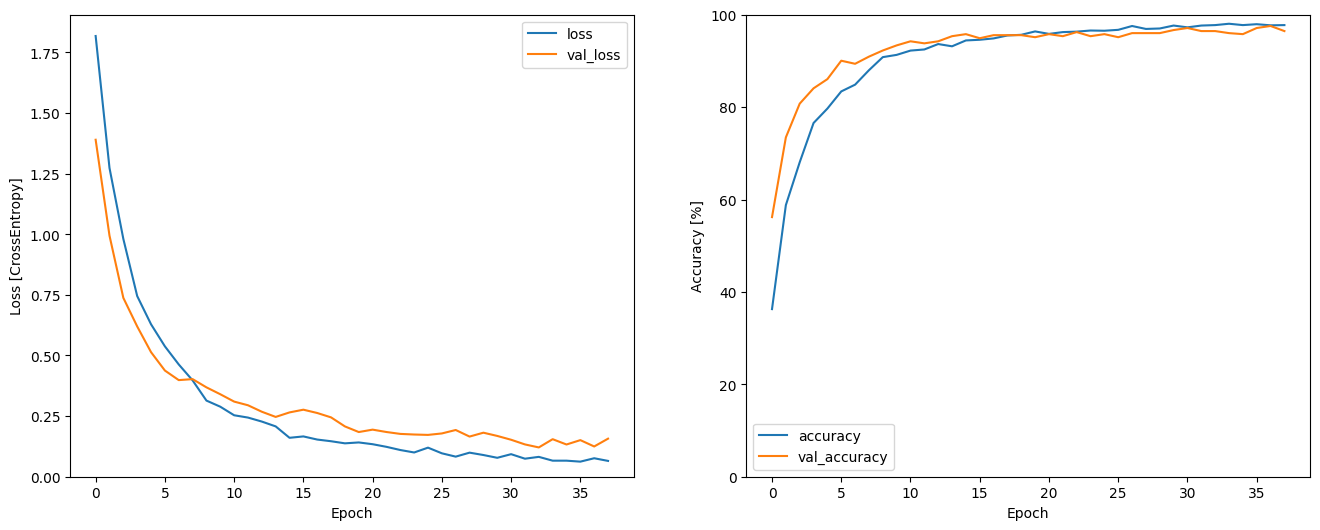

In [32]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Mostrar una matriz de confusión

In [33]:
y_pred = model.predict(val_ds_spectrogram)

8/8 [==============================] - 1s 44ms/step


In [34]:
y_pred = tf.argmax(y_pred, axis=1)

In [35]:
y_true = tf.concat(list(val_ds_spectrogram.map(lambda s,lab: lab)), axis=0)

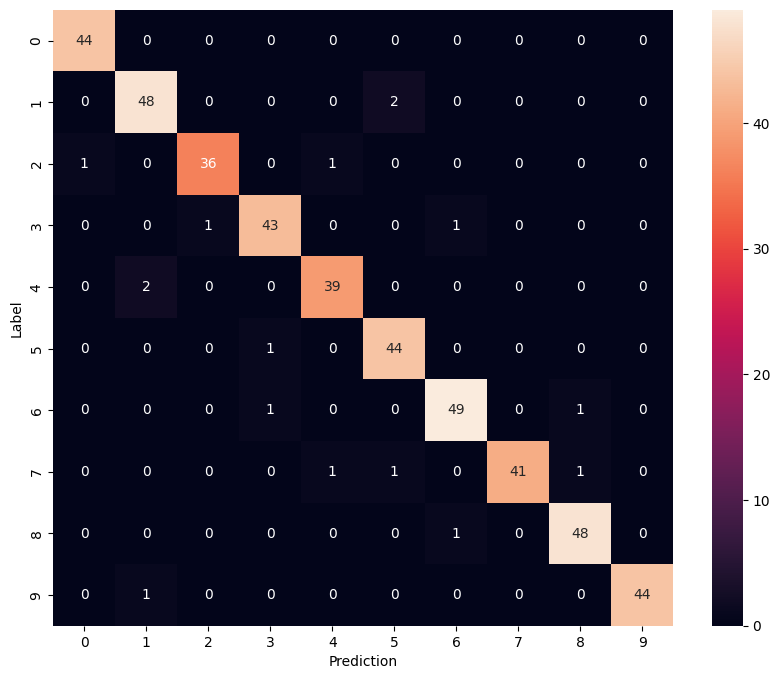

In [36]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Inferir sobre un archivo de audio

Probamos sobre un ejemplo del dataset

In [37]:
ejemplo = 20

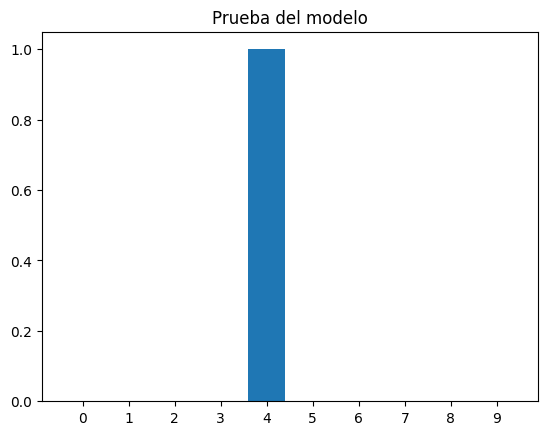

In [38]:

label = class_names[batch_label[ejemplo]]
x = batch_audio[ejemplo]
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = class_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Prueba del modelo')
plt.show()

display(Audio(waveform, rate=8000))

Las métricas son muy buenas y el modelo no parece sobreajustar. Además en la matriz de confusión se pueden ver los buenos resultados del modelo con los datos de validación, los pocos casos en los que se equivocó parecen lógicos.

## Construir y Entrenar el Modelo Recurrente

Volvemos a cargar los datos y armar los espectrogramas.

In [39]:

# Acceder a la división 'train' del conjunto de datos
train_dataset_rec = dataset['train']

train_dataset_rec = train_dataset_rec.map(lambda audio, label: preprocess_audio(audio, label))

In [40]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [41]:
train_spectrogram_ds_rec = make_spec_ds(train_dataset_rec)


In [42]:

example_spectrograms_rec = []
example_spect_labels_rec = []
# Iterar sobre el conjunto de datos de entrenamiento de espectrogramas
for spectrogram, label in train_spectrogram_ds_rec:
    example_spectrograms_rec.append(spectrogram.numpy()) # Convertir el espectrograma a numpy y añadirlo a la lista
    example_spect_labels_rec.append(label.numpy()) # Convertir la etiqueta a numpy y añadirla a la lista

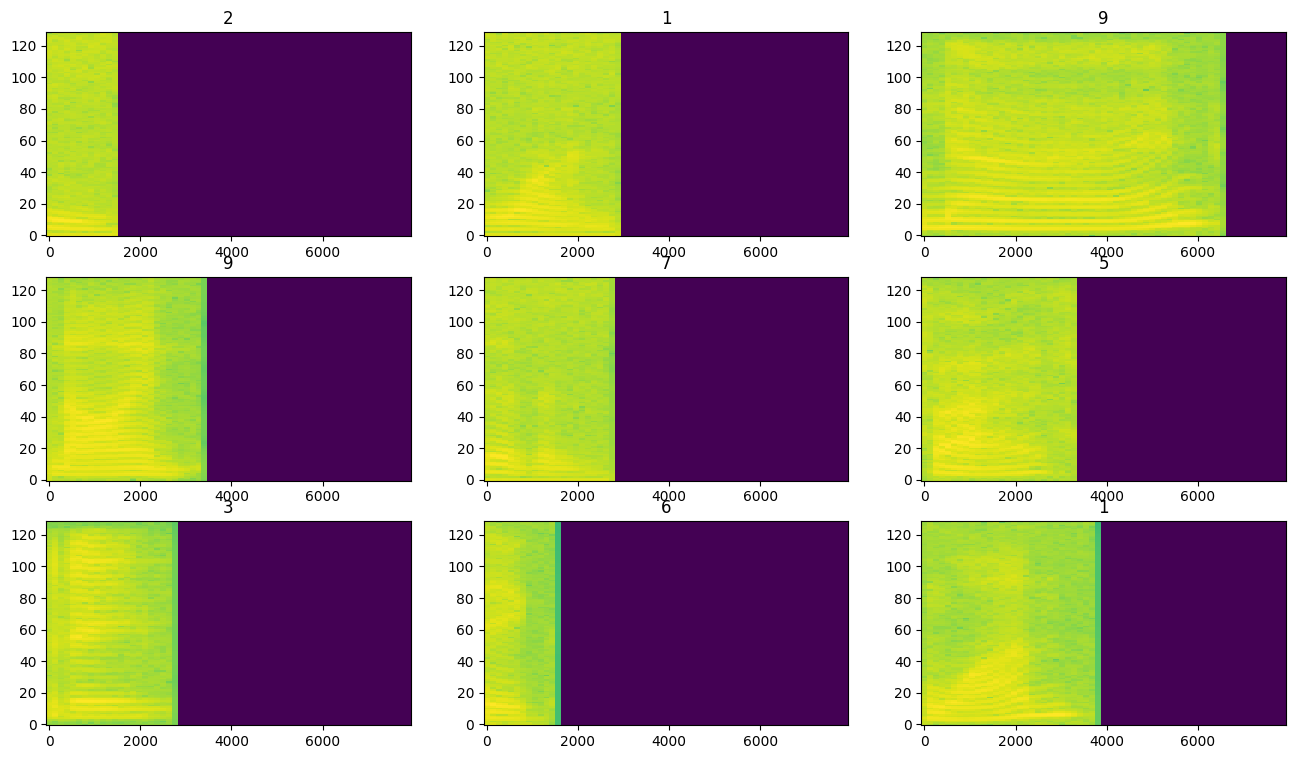

In [43]:
# Visualizar los espectrogramas
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    spectrogram = example_spectrograms_rec[i]
    label = example_spect_labels_rec[i]

    plot_spectrogram(spectrogram, ax)
    ax.set_title(class_names[label])

plt.show()

In [44]:

print(f'Spectrogram shape: {example_spectrograms_rec[0].shape}')
print(f'Label: {example_spect_labels_rec[0]}')


Spectrogram shape: (61, 129, 1)
Label: 2


Dividimos cada espectrograma en 11 nuevos tramos, de largo 10 y con un solapamiento de 5.

In [45]:



X = []
y = []

segment_width = 10 # Largo de los nuevos tramos
stride = 5  # Definimos el solapamiento en 5 elementos

# Recorre los espectrogramas
for spectrogram, label in zip(example_spectrograms_rec, example_spect_labels_rec):
    segments_per_spectrogram = []
    # Divide el espectrograma en segmentos con solapamiento
    for start in range(0, spectrogram.shape[0] - segment_width + 1, stride):
        segment = spectrogram[start:start + segment_width]
        segments_per_spectrogram.append(segment)
    X.append(segments_per_spectrogram)
    y.append(label)

# Convierte a numpy arrays
X = np.array(X)
y = np.array(y)

# Muestra la forma del primer espectrograma y sus segmentos
print(f"Spectrogram shape: {X[0].shape}")

Spectrogram shape: (11, 10, 129, 1)


In [46]:

len(X)

2500

In [47]:
print(f'Spectrogram shape: {X[1].shape}')
print(f'Label: {y[1]}')

Spectrogram shape: (11, 10, 129, 1)
Label: 1


In [48]:
num_classes = len(class_names)

# Mezclar los datos antes de dividirlos en entrenamiento y validación
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
y = to_categorical(y, num_classes)


In [49]:
# Dividir los datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
segment_lenght = X[0].shape[0]
img_height = X[0].shape[2]
img_width = X[0].shape[1]

In [51]:
model_cnlst = Sequential()
# Capas convolucionales
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu'), input_shape=(segment_lenght, img_width, img_height, 1)))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(Conv2D(16, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(BatchNormalization()))
model_cnlst.add(TimeDistributed(Flatten()))
model_cnlst.add(Dropout(0.5))
# Capa recurrente
model_cnlst.add(LSTM(32, return_sequences=False, dropout=0.5))
# Capas de salida
model_cnlst.add(Dense(64, activation='relu'))
model_cnlst.add(Dense(32, activation='relu'))
model_cnlst.add(Dropout(0.5))
model_cnlst.add(Dense(num_classes, activation='softmax'))
# Resumen del modelo
model_cnlst.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 11, 8, 127, 32)    320       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 11, 6, 125, 32)    9248      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 11, 3, 62, 32)     0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 11, 1, 60, 16)     4624      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 11, 1, 60, 16)    

Compilamos y entrenamos el modelo durante 50 epochs con early stopping:

In [52]:
# Compilar el modelo
model_cnlst.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo con callbacks
history = model_cnlst.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=8,
                          callbacks=[early_stopping, model_checkpoint])

# Evaluación del modelo en el conjunto de validación
val_loss, val_accuracy = model_cnlst.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")


Epoch 1/50
250/250 [==============================] - 63s 237ms/step - loss: 2.3013 - accuracy: 0.1240 - val_loss: 2.1969 - val_accuracy: 0.1760
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 59s 236ms/step - loss: 2.0653 - accuracy: 0.1850 - val_loss: 1.7086 - val_accuracy: 0.3460
Epoch 3/50
250/250 [==============================] - 55s 220ms/step - loss: 1.7969 - accuracy: 0.2770 - val_loss: 1.3510 - val_accuracy: 0.4100
Epoch 4/50
250/250 [==============================] - 55s 220ms/step - loss: 1.5579 - accuracy: 0.3575 - val_loss: 1.2251 - val_accuracy: 0.4920
Epoch 5/50
250/250 [==============================] - 58s 232ms/step - loss: 1.3481 - accuracy: 0.4390 - val_loss: 0.8977 - val_accuracy: 0.6640
Epoch 6/50
250/250 [==============================] - 55s 221ms/step - loss: 1.2229 - accuracy: 0.5090 - val_loss: 0.8531 - val_accuracy: 0.6680
Epoch 7/50
250/250 [==============================] - 53s 210ms/step - loss: 1.1390 - accuracy: 0.5480 - val_loss: 0.8156 - val_accuracy: 0.6620
Epoch 8/50
250/250 [==============================] - 55s 220ms/step - loss: 0.9730 - accuracy: 0.6235 - val_loss: 0.6968 - val_accuracy: 0.7

Text(0, 0.5, 'Accuracy [%]')

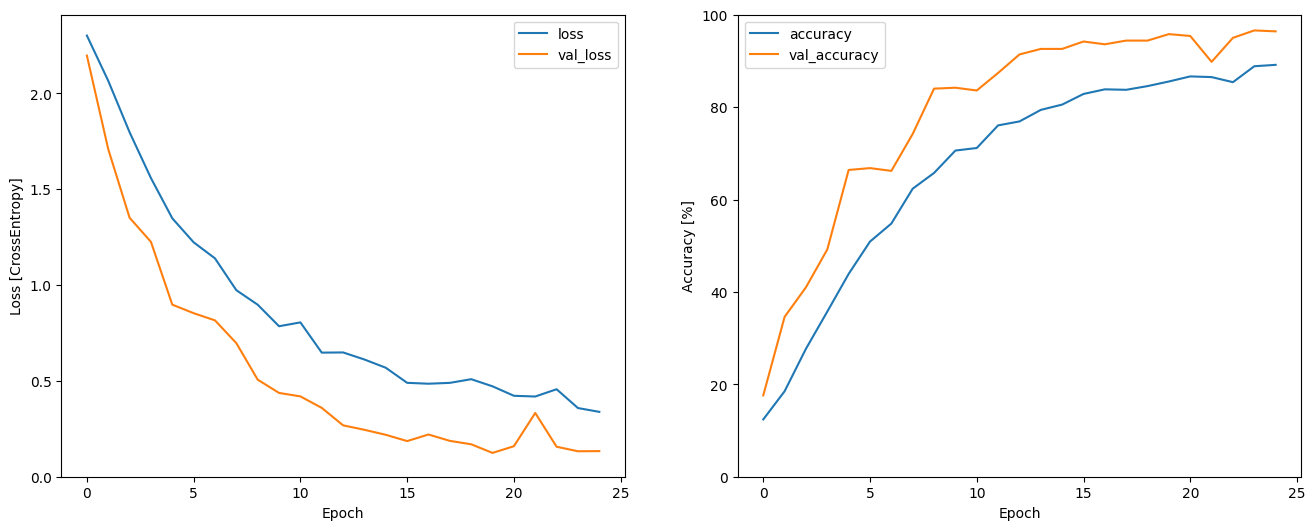

In [53]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Mostrar una matriz de confusión

16/16 [==============================] - 4s 261ms/step


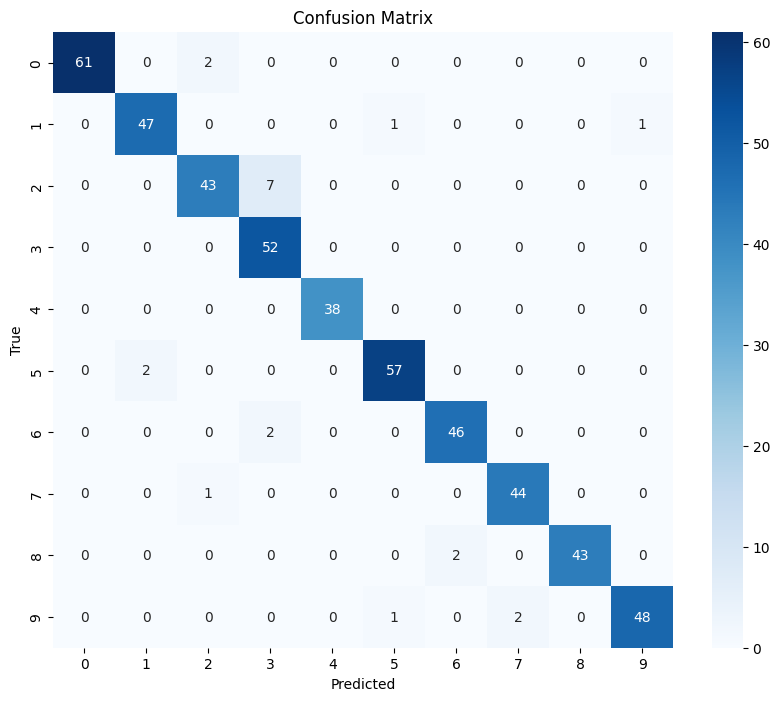

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.96      0.96      0.96        49
           2       0.93      0.86      0.90        50
           3       0.85      1.00      0.92        52
           4       1.00      1.00      1.00        38
           5       0.97      0.97      0.97        59
           6       0.96      0.96      0.96        48
           7       0.96      0.98      0.97        45
           8       1.00      0.96      0.98        45
           9       0.98      0.94      0.96        51

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



In [63]:
# Obtener las predicciones del modelo sobre el conjunto de validación
y_val_pred = model_cnlst.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Convertir las etiquetas de validación a su forma original
y_val_true = np.argmax(y_val, axis=1)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Imprimir un reporte de clasificación para obtener más métricas
print(classification_report(y_val_true, y_val_pred_classes, target_names=class_names))

### Inferir sobre un archivo de audio

In [59]:
ejemplo = 8


In [60]:
label = class_names[batch_label[ejemplo]]
x = batch_audio[ejemplo]
waveform = x
spectrogram  = get_spectrogram(x)
segment_width = 10 # Largo de los nuevos tramos
stride = 5  # Definimos el solapamiento en 5 elementos
# Divide el espectrograma en segmentos con solapamiento
segments_spectrogram_ej = []
for start in range(0, spectrogram.shape[0] - segment_width + 1, stride):
    segment_ej = spectrogram[start:start + segment_width]
    segments_spectrogram_ej.append(segment_ej)

# Convierte a numpy arrays
segments_spectrogram_ej = np.array(segments_spectrogram_ej)



In [61]:
# Muestra la forma del primer espectrograma y sus segmentos
print(f"Spectrogram shape: {segments_spectrogram_ej.shape}")

Spectrogram shape: (11, 10, 129, 1)


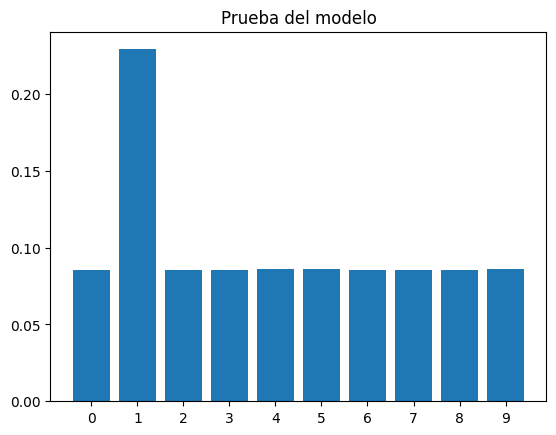

In [62]:


segments_spectrogram_ej = segments_spectrogram_ej[tf.newaxis, ...]

prediction = model_cnlst(segments_spectrogram_ej)
x_labels = class_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Prueba del modelo')
plt.show()

display(Audio(waveform, rate=8000))

Las métricas también son muy buenas, incluso mejor que las del modelo convolucional. Lo que nos llamó la atención es el resultado al inferir en un audio, en el gráfico se puede ver que en todos los números tiene un valor de probabilidad. Entendemos que es porque los espectrogramas tienen mucho espacio con valor cero.